In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import deepcopy
import subprocess
import rasterio
from rasterio.plot import show
import geopandas as gpd
from funcs import *
from scipy.ndimage import zoom
from sklearn.metrics import mean_squared_error
from rasterio import mask as msk

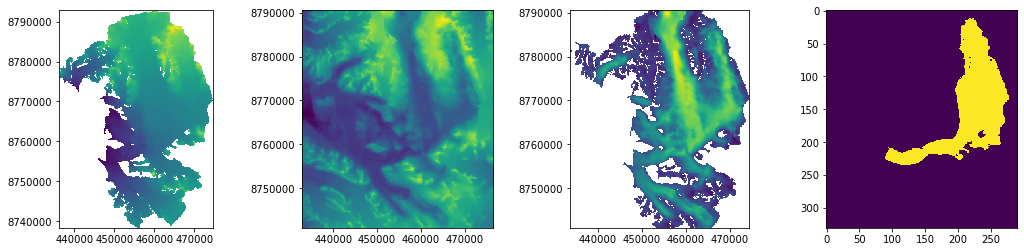

In [2]:
### data from lindbäck et al. (2018)
surf_o = rasterio.open("./kronebreen/TIGRIF_DEM_ice_surface_150m_v1.tif") #from 2014
thk_o = rasterio.open("./kronebreen/TIGRIF_DEM_ice_thickness_150m_1.tif") #from 2014, 2015, 2016 and some from 2000s
bed_o = rasterio.open("./kronebreen/TIGRIF_DEM_subglacial_elevation_150m_v1.tif")

surf = surf_o.read(1)
thk = thk_o.read(1)
bed = bed_o.read(1)

### rgi outline
outline = gpd.read_file('./kronebreen/rgi_outlines/07_rgi60_Svalbard.shp')
outline_Kr = outline.to_crs(bed_o.crs)
outline_Kr = outline_Kr.loc[outline_Kr['RGIId'] == 'RGI60-07.01464', 'geometry']

bed_mask, bed_mask_meta = rasterio.mask.mask(bed_o, outline_Kr, crop=False)
surf_mask, surf_mask_meta = msk.mask(surf_o, outline_Kr, crop=False)
thk_mask, thk_mask_meta = msk.mask(thk_o, outline_Kr, crop=False)
mask_Kr = np.ones_like(bed_mask[0])
mask_Kr[bed_mask[0]>1e37]=0

fig, ax = plt.subplots(1,4, figsize=(18,4))
field1 = show(surf_o, ax = ax[0])
field2 = show(bed_o, ax = ax[1])
field3 = show(thk_o, ax = ax[2])
#outline.plot(ax=ax[2])
field4 = show(mask_Kr)

In [4]:
#### data from Jack ###
import scipy.io
mat_DEM_Vel = scipy.io.loadmat('./kronebreen/HDF_2021_10_06.mat')
x_50m, y_50m = np.meshgrid(mat_DEM_Vel['HDF'][0,0][0], np.arange(np.min(mat_DEM_Vel['HDF'][0,0][1]), np.max(mat_DEM_Vel['HDF'][0,0][1])+10050, 50))

Z_50m_09 = np.zeros((int(((np.max(y_50m)+50)-np.min(y_50m))/50), int((np.max(x_50m)+50-np.min(x_50m))/50)))
Z_50m_09[:np.shape(Z_50m_09)[0]-int(10000/50),:] = mat_DEM_Vel['HDF'][0,0][3]
Z_50m_14 = np.zeros((int(((np.max(y_50m)+50)-np.min(y_50m))/50), int((np.max(x_50m)+50-np.min(x_50m))/50)))
Z_50m_14[:np.shape(Z_50m_14)[0]-int(10000/50),:] = mat_DEM_Vel['HDF'][0,0][4]

R2_50m_Vx = mat_DEM_Vel['HDF'][0,0][6]
R2_50m_Vx[np.isnan(R2_50m_Vx)] = 0
R2_50m_Vy = mat_DEM_Vel['HDF'][0,0][7]
R2_50m_Vy[np.isnan(R2_50m_Vy)] = 0
R2_50m_Vel = mat_DEM_Vel['HDF'][0,0][8]
R2_50m_Vel[np.isnan(R2_50m_Vel)] = 0

mat_RADAR = scipy.io.loadmat('./kronebreen/HDF_radar_data.mat')
x_rad = mat_RADAR['HDF_radar_data'][0,0][0]
y_rad = mat_RADAR['HDF_radar_data'][0,0][1]
xy_rad = np.stack([x_rad, y_rad], axis=1)[:,:,0]
rad = mat_RADAR['HDF_radar_data'][0,0][2]

In [5]:
### official 50 m NPI DEM ###
NPI_DEM_o = rasterio.open("./kronebreen/S0_DTM50.tif")
window = (NPI_DEM_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1))
NPI_50m_DEM = np.zeros_like(Z_50m_09)
NPI_50m_DEM[1:,1:] = np.flip(NPI_DEM_o.read(1, window = window), axis=0)  ## NPI_DEM is not correctly oriented when imported (no idea why), therefore it needs to be flipped

In [6]:
### get mask of Kongsbreen, reproject it and set it to the correct spot in the raster ###
outline_Ko = outline.to_crs(NPI_DEM_o.crs)
outline_Ko = outline_Ko.loc[outline_Ko['RGIId'] == 'RGI60-07.01482', 'geometry']
NPI_mask, NPI_mask_meta = rasterio.mask.mask(NPI_DEM_o, outline_Ko, crop=True)
NPI_mask = np.flip(NPI_mask[0], axis=0)
NPI_mask[NPI_mask<-1e37] = 0
NPI_mask[NPI_mask>0] = 1

#coordinates of upper left corner of cropped (using window) NPI DEM
x_ul_NPI_DEM = window.col_off*50+NPI_DEM_o.transform[2]  
y_ul_NPI_DEM = window.row_off*-50+NPI_DEM_o.transform[5]

## amount of pixels that NPI_mask needs to be shifted to be at right spot in the raster
shift_x = int((NPI_mask_meta[2] - x_ul_NPI_DEM)/50)
shift_y = int((NPI_mask_meta[5] - y_ul_NPI_DEM)/50)

mask_50m_Ko = np.zeros_like(NPI_50m_DEM)
mask_50m_Ko[(np.shape(mask_50m_Ko)[0]-np.shape(NPI_mask)[0]+shift_y):(np.shape(mask_50m_Ko)[0]+shift_y), shift_x:(shift_x+np.shape(NPI_mask)[1])]=NPI_mask

In [8]:
### masks ###
#mask_50m = -1*np.logical_or(np.isnan(Z_50m_14), np.isnan(Z_50m_09))+1
mask_50m = -1*np.isnan(Z_50m_14)+1
retreat_50m_mask = np.zeros_like(mask_50m)
retreat_50m_mask[np.logical_and(NPI_50m_DEM<100, np.logical_and(Z_50m_09>1, -1*mask_50m+1))] = 1
retreat_50m_mask[retreat_50m_mask+mask_50m==2]=0

#retreat_50m_mask = np.logical_and(np.logical_and(-1*np.isnan(Z_50m_09)+1, mask_50m == 0), NPI_50m_DEM < 100)

#mask_50m *= (-1*retreat_50m_mask+1)

mask_50m[np.shape(mask_50m)[0]-int(10000/50):,:]=0

mask_50m_full = mask_50m_Ko + mask_50m
mask_50m_full[mask_50m_full>0] = 1

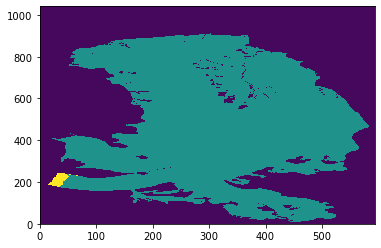

In [7]:
plt.pcolor(retreat_50m_mask*2+mask_50m_full)

In [9]:
### set bed elevation under water to -700 m ###
#ocean_50m = (np.logical_and(NPI_50m_DEM<=10, mask_50m==0))
NPI_50m_DEM[retreat_50m_mask==1] = 0

### fill nan values ###
Z_50m_09[mask_50m_full==0]=NPI_50m_DEM[mask_50m_full==0]
Z_50m_09[np.isnan(Z_50m_09)] = NPI_50m_DEM[np.isnan(Z_50m_09)]

Z_50m_14[mask_50m_full==0]=NPI_50m_DEM[mask_50m_full==0]
Z_50m_14[np.isnan(Z_50m_14)] = NPI_50m_DEM[np.isnan(Z_50m_14)]

### calculate dhdt ###
dhdt_50m_0914 = (Z_50m_14 - Z_50m_09)/5
dhdt_50m_0914[np.isnan(dhdt_50m_0914)] = 0

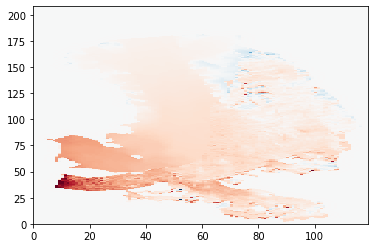

In [10]:
## fit dhdt for Kongsbreen ##
poly = np.poly1d(np.polyfit(NPI_50m_DEM[mask_50m == 1],dhdt_50m_0914[mask_50m == 1],1))
dhdt_50m_fit = poly(NPI_50m_DEM)
dhdt_50m_fit[mask_50m == 1]=0
dhdt_50m_fit[mask_50m_Ko == 0]=0

## full dhdt
dhdt_50m_full = dhdt_50m_fit+dhdt_50m_0914

plt.pcolor(zoom(dhdt_50m_full, 50/250), cmap='RdBu', vmin=-5, vmax=5)

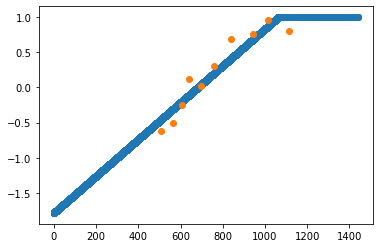

In [11]:
### mass balance from Jack in cm.w.eq. ###
import pandas as pd

smb_xyz_df = pd.read_excel ('./kronebreen/HDF_mass_balance.xlsx', 0, header=None)
smb_net_df = pd.read_excel ('./kronebreen/HDF_mass_balance.xlsx', 3, header=None)

smb_x = np.array(smb_xyz_df.loc[:,1])
smb_y = np.array(smb_xyz_df.loc[:,2])
smb_z = np.array(smb_xyz_df.loc[:,3])

smb_net_0914 = np.array(smb_net_df.loc[1:,7:12])/100*(10/9)   #convert to m.ice.eq.
smb_net_0914 = np.nanmean(smb_net_0914, axis=1)

### interpolate smb with elevation ###
from scipy import optimize

#def piecewise_linear(x):
#    return np.piecewise(x, [x < 0, x>=0], [lambda x: -x, lambda x: x])

#p , e = optimize.curve_fit(piecewise_linear, smb_z, smb_net_1421)
#test = piecewise_linear(Z_14, *p)

poly = np.poly1d(np.polyfit(smb_z,smb_net_0914,1))
smb_50m_fit = poly(NPI_50m_DEM)
smb_50m_fit[smb_50m_fit<-2] = -2
smb_50m_fit[smb_50m_fit>1] = 1


plt.scatter(NPI_50m_DEM, smb_50m_fit)
plt.scatter(smb_z, smb_net_0914)

In [12]:
### velocity from Jack ###
vel_xyz_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 1, header=None)
vel_x = np.array(vel_xyz_df.loc[:,1])
vel_y = np.array(vel_xyz_df.loc[:,2])
vel_z = np.array(vel_xyz_df.loc[:,3])

vel_df = pd.read_excel ('./kronebreen/HDF_stake_velocities.xlsx', 0, header=None)
vel_0914 = np.nanmean(np.array(vel_df.loc[3:,range(10,18,2)]), axis=1)


In [13]:
### adjust resolution ###

data_res = 50
res = 250
resample = data_res/res

Z_09 = zoom(Z_50m_09, resample)
Z_14 = zoom(Z_50m_14, resample)
dhdt_full = zoom(dhdt_50m_full, resample)
smb_fit = zoom(smb_50m_fit, resample)
NPI_DEM = zoom(NPI_50m_DEM, resample)
R2_Vel = zoom(R2_50m_Vel, resample)
R2_Vx = zoom(R2_50m_Vy, resample)
R2_Vy = zoom(R2_50m_Vy, resample)

mask = np.around(zoom(mask_50m_full, resample), 0)
mask_Kr = np.around(zoom(mask_50m, resample), 0)
mask_Ko = np.around(zoom(mask_50m_Ko, resample), 0)

retreat_mask = NPI_DEM<-500

x = zoom(x_50m, resample)
y = zoom(y_50m, resample)

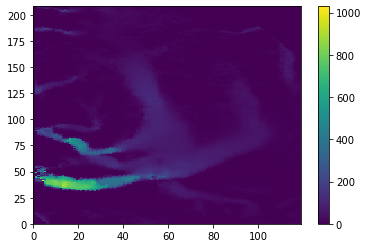

In [16]:
### ITS_LIVE velocities
itslive_vel_o = rasterio.open("./kronebreen/vel_ITSLIVE_resample.tif")
itslive_vx_o = rasterio.open("./kronebreen/vx_ITSLIVE_proj.tif")
itslive_vy_o = rasterio.open("./kronebreen/vy_ITSLIVE_proj.tif")

window_vel = (itslive_vel_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1))
itslive_vel = np.flip(itslive_vel_o.read(1, window = window_vel), axis = 0)
itslive_vx = np.flip(itslive_vx_o.read(1, window = window_vel), axis = 0)
itslive_vy = np.flip(itslive_vy_o.read(1, window = window_vel), axis = 0)

vel_mes = np.zeros_like(mask)
vel_mes[:,1:] = itslive_vel
vel_mes[vel_mes<-1e30] = 0

vx_mes = np.zeros_like(mask)
vx_mes[:,1:] = itslive_vx
vx_mes[vel_mes<-1e30] = 0

vy_mes = np.zeros_like(mask)
vy_mes[:,1:] = itslive_vy
vy_mes[vel_mes<-1e30] = 0

fig, ax = plt.subplots()
field = ax.pcolor(vel_mes)
plt.colorbar(field, ax = ax)

In [ ]:
#gr = np.meshgrid(range(119), range(208))
#index_y = get_nearest(x,y,gr[1],x_rad, y_rad)
#index_x = get_nearest(x,y,gr[0],x_rad, y_rad)
#grid_points = list(set(zip(index_y, index_x)))
#
#n = int(len(grid_points)/10)
#random_index = np.random.choice(len(grid_points), n, replace=False)  
#grid_points_random = [grid_points[i] for i in random_index]
#bed_loc_random = [rad[i] for i in random_index]
#grid_points_location = [tuple(i) for i in np.array(grid_points)[np.logical_and(np.array(grid_points)[:,1]<50, np.array(grid_points)[:,0]<200)]]
#
#radar_mask = np.zeros_like(NPI_DEM)
#for i,q in enumerate(grid_points):
#    radar_mask[q]=rad[i]

In [17]:
### filter outliers in dhdt ###
dhdt_full_new = np.zeros_like(dhdt_full)
for i in range(np.shape(dhdt_full)[0]):
    for j in range(np.shape(dhdt_full)[1]):
        if mask[i, j]==0:
                dhdt_full_new[i, j] = 0
        else:
            y_f, x_f = np.ogrid[:np.shape(dhdt_full)[0], :np.shape(dhdt_full)[1]]
            circle = (y_f - i) ** 2 + (x_f - j) ** 2 <= 20
            local_med = np.median(dhdt_full[np.logical_and(circle, mask==1)])
            local_std = np.std(dhdt_full[np.logical_and(circle, mask==1)])
            if dhdt_full[i,j] >  local_med + 1* local_std:
                dhdt_full_new[i, j]= local_med + 1* local_std
            elif dhdt_full[i,j] < local_med - 1* local_std:
                dhdt_full_new[i, j]= local_med - 1* local_std              
            else:
                dhdt_full_new[i,j] = dhdt_full[i,j]

In [18]:
### ice temperature ###
ice_temp = 273
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))
print(A)

3.9565534675428266e-24


In [19]:
filename = "kronebreen_kongsbreen_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {#"ocean.always_grounded": "yes",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.8,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [20]:
WRIT_FILE = 'kronebreen_kongsbreen_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 900.0             # [kg m-3]

ny, nx = np.shape(Z_09)
Lx = nx * res  # in m
Ly =  ny * res # in m

x_in = np.linspace(-Lx/2, Lx/2, nx)
y_in = np.linspace(-Ly/2, Ly/2, ny)

B_rec = NPI_DEM
B_init = deepcopy(B_rec)
ice_surface_temp = np.ones((ny, nx))*ice_temp
#M_refs = np.nan_to_num(M_refs)
#M_refs *= mask

h_rec = NPI_DEM - B_rec

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y_in],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x_in],
        'thk':  ['m',
                 'ice thickness',
                 'land_ice_thickness',
                 1.0,
                 h_rec],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 B_rec],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             273,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0,
                                  smb_fit * ice_density * mask]
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  kronebreen_kongsbreen_initialSetup.nc  created



In [21]:
def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

def get_nearest(x_ref,y_ref,reference, x_dat, y_dat):
    grid_temp = []
    for i in range(len(x_dat)):
        abslat = np.abs(x_ref-x_dat[i])
        abslon= np.abs(y_ref-y_dat[i])

        c = np.maximum(abslon,abslat)
        latlon_idx = np.argmin(c)
        grid_temp.append(reference.flat[latlon_idx])
    return grid_temp

def neighbors(a, radius, rowNumber, columnNumber):
     return [[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else 0
                for j in range(columnNumber-1-radius, columnNumber+radius)]
                    for i in range(rowNumber-1-radius, rowNumber+radius)]

In [22]:
def create_script(forward_or_iteration, nx, ny):
    print("""#!/bin/bash
    ###### run script for experiment synthetic1 ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx {} -My {} -Mz 50 -Mbz 1 -Lz 1500 -Lbz 1"'.format(nx, ny))
    print('PHYS="-stress_balance ssa+sia -sia_flow_law isothermal_glen -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    #print('OCEAN="-dry"')
    print('CONF="-config_override kronebreen_kongsbreen_conf.nc"')

    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.2 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 1e5"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# initialize Kronebreen"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag,enthalpybase,bwat,strain_rates"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS -o_size big"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times -o_size big -extra_vars $EXVARS"')
    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $CONF $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [23]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('kronebreen_kongsbreen_initialize.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward', nx, ny)
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()
    
!chmod +x kronebreen_kongsbreen_initialize.sh
!./kronebreen_kongsbreen_initialize.sh 4 kronebreen_kongsbreen_initialSetup.nc 1 kronebreen_kongsbreen_output.nc > kronebreen_kongsbreen_output_log.txt

Tau: 1.3920452871665763
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
dH: 1.4064830798891736


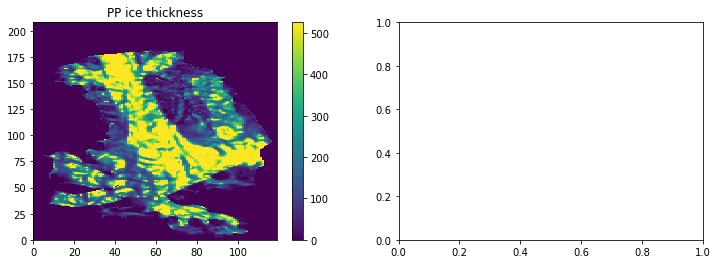

In [24]:
import richdem as rd
import math

dH = (np.nanmax(NPI_DEM[mask==1])-np.nanmin(NPI_DEM[mask==1]))/1000 #in km

tau = 0.005+1.598*dH-0.435*dH**2  #Haeberli and Hoelzle
print('Tau: {}'.format(tau))

slope = rd.TerrainAttribute(rd.rdarray(NPI_DEM, no_data=-9999), attrib='slope_riserun')/res
slope[slope<0.015] = 0.015
tan_slope = np.arctan(slope)
sin_slope = np.sin(tan_slope)
H=((tau*.5)*1e5)/(sin_slope*9.8*ice_density)

fig, ax = plt.subplots(1,2, figsize=(12,4))
field = ax[0].pcolor(H*mask)
fig.colorbar(field, ax = ax[0])
print('dH: {}'.format(dH))
ax[0].set_title('PP ice thickness')

def smooth_stress_coupling(H, field, mask, scl, max_scl, min_scl):
    field_new = np.zeros_like(field)
    for i in range(nx):
        for j in range(ny):
            if mask[j,i]==0:
                field_new[j,i] = field[j,i]
            else:
                x, y = np.ogrid[:np.shape(H)[0], :np.shape(H)[1]]
                coupling_length = scl*(H[j,i]/res)**2
                circle = (y - i) ** 2 + (x - j) ** 2 <= (min(max(coupling_length, min_scl),max_scl)/2)**2
                field_new[j,i]= np.mean(field[np.logical_and(circle, mask==1)])
    return field_new
         

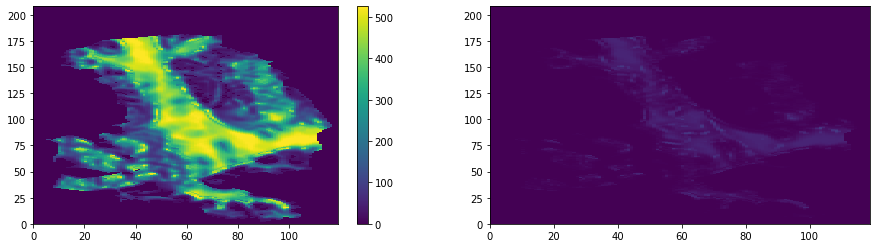

In [25]:
H_smooth = deepcopy(H)
sin_slope_smooth = deepcopy(sin_slope)
for i in range(20):
    sin_slope_smooth = smooth_stress_coupling(H_smooth, sin_slope, mask, 4, 8,2)
    H_smooth =(tau*.5)*1e5/(sin_slope_smooth*9.81*ice_density)

fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(H_smooth*mask)
fig.colorbar(field, ax=ax[0])
T=(2*A*(9.8*ice_density)**3)/5
D=mask*T*H_smooth**5*(slope)**2
field2 = ax[1].pcolor(D, vmax = 1e-1)

In [23]:
ocean_boundary = np.zeros_like(mask_Kr)
for i in range(nx):
    for j in range(ny):
        if mask[j,i] == 0:
            continue
        if np.count_nonzero([item for sublist in (neighbors(retreat_mask, 1, j, i)) for item in sublist])>2:
            if np.count_nonzero([item for sublist in (neighbors(mask_Kr, 1, j, i)) for item in sublist]) > 0:
                ocean_boundary[j,i] = 1

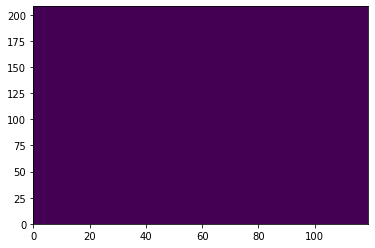

In [25]:
plt.pcolor(ocean_boundary)

In [30]:
### get measured bed elevation in numpy array ###

#find the index that is associated with the radar x-y coordiantes
gr = np.meshgrid(range(119), range(208))
index_y = get_nearest(x,y,gr[1],x_rad, y_rad) 
index_x = get_nearest(x,y,gr[0],x_rad, y_rad)
grid_points = list(zip(index_y, index_x))

# take the mean of all measured thicknesses that fall on one grid point
df_place = pd.DataFrame({"inds":list(zip(index_y, index_x)),"rad":rad[:,0], "x_rad":x_rad[:,0], "y_rad": y_rad[:,0]})
df_place = df_place.groupby('inds').mean()
inds = np.array(df_place.index)
bed_loc = df_place['rad']
x_rad_sample = df_place['x_rad']
radar_mask = np.zeros_like(NPI_DEM)
radar_bed = np.zeros_like(NPI_DEM)
radar_x = np.zeros_like(NPI_DEM)

n = int(len(inds)/2)
random_index = np.random.choice(len(inds), n, replace=False)  

# modify for-statement to sample measured bed elevations according to study question
for i in inds[random_index]:
    radar_mask[i]=1
    radar_bed[i] = bed_loc[i]
    radar_x[i] = x_rad_sample[i]

In [212]:
### bed recovery ###
S_rec = deepcopy(NPI_DEM)
S_rec[mask==0]=np.nan
S_rec = gauss_filter(S_rec, 1, 3)
S_rec[mask==0]=NPI_DEM[mask==0]
S_init = deepcopy(S_rec)

H_smooth_D = deepcopy(H_smooth)
H_smooth_D[np.logical_and(D>1e-1, ocean_boundary!=1)] = (1e-1/(T*(slope[np.logical_and(D>1e-1, ocean_boundary!=1)])**2))**(1/5)

B_rec = deepcopy(S_rec)
B_rec[mask==1] = np.maximum(S_rec[mask==1]-700, S_rec[mask==1]-H_smooth_D[mask==1])
B_rec[mask==0] = np.nan
B_rec = gauss_filter(B_rec, .6, 3)
B_rec[np.logical_or(B_rec > S_rec, mask==0)]=S_rec[np.logical_or(B_rec > S_rec, mask==0)]
B_rec[retreat_mask==1]=-700

#B_rec[radar_mask == 1] = radar_bed[radar_mask == 1]
    
B_init = deepcopy(B_rec)

dh_ref = deepcopy(dhdt_full)

tauc_rec = copy(tauc_fit)
tauc_rec[mask_Kr==1] = tauc[mask_Kr==1]
tauc_rec[np.isnan(tauc_rec)] = 1e8

B_rec_all = []
dh_all = []
misfit_all = []
B_misfit_vs_iter=[]
dh_misfit_vs_iter=[]
S_rec_all = []
vel_all = []

pmax = 100
dt = .1
beta = .5
bw = 2

!cp kronebreen_kongsbreen_output.nc kronebreen_kongsbreen_iteration_out.nc
    

original_stdout = sys.stdout
with open('kronebreen_kongsbreen_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x kronebreen_kongsbreen_iteration_script.sh

<ipython-input-21-155111e60a30>:14: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [213]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_rec - B_rec
        
    !cp kronebreen_kongsbreen_iteration_out.nc kronebreen_kongsbreen_iteration_in.nc
    nc_updated = NC('kronebreen_kongsbreen_iteration_in.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated['tauc'][0,:,:]= tauc_rec
    nc_updated.close()
    
    cmd = ["./kronebreen_kongsbreen_iteration_script.sh", '6', 'kronebreen_kongsbreen_iteration_in.nc', str(dt), 'kronebreen_kongsbreen_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('kronebreen_kongsbreen_iteration_log.txt', 'a'))
    
    h_rec = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    vel = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velbar_mag', 0)
    
    u = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'uvelsurf', 0)
    v = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'vvelsurf', 0)

    misfit = shift((dh_rec-dh_ref), u, v, 0.3)*mask

    B_rec = B_rec - beta * (misfit)
    #tauc_rec = tauc_rec + beta * misfit * 1e4
    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.05) * misfit[np.logical_and(mask==1, h_rec>20)] 
                
    slope_iter = rd.TerrainAttribute(rd.rdarray(S_rec, no_data=-9999), attrib='slope_riserun')/res
    
    H_rec = S_rec - B_rec
    D_iter = mask*T*H_rec**5*(slope_iter)**2
    H_rec[np.logical_and(D_iter>1e-1, ocean_boundary!=1)] = (1e-1/(T*(slope_iter[np.logical_and(D_iter>1e-1, ocean_boundary!=1)])**2))**(1/5)
    B_rec = S_rec - H_rec
    
    ### fix bed at locations of known ice thickness
    #B_rec[radar_mask == 1] = radar_bed[radar_mask == 1]

    B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
    B_rec[B_rec>NPI_DEM]=NPI_DEM[B_rec>NPI_DEM]
    S_rec[mask == 0]= NPI_DEM[mask == 0]
    B_rec[mask == 0]= NPI_DEM[mask == 0]
    
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    misfit[mask==0] = np.nan
    misfit_all.append(misfit)
    S_rec_all.append(S_rec)
    vel_all.append(vel)
    
    B_misfit_vs_iter.append(np.mean(abs(B_rec-B_init)))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))

  1%|          | 1/100 [00:03<05:56,  3.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  2%|▏         | 2/100 [00:06<05:10,  3.17s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  3%|▎         | 3/100 [00:09<04:55,  3.04s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  4%|▍         | 4/100 [00:12<04:46,  2.98s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  5%|▌         | 5/100 [00:15<04:37,  2.92s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  6%|▌         | 6/100 [00:17<04:27,  2.85s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  7%|▋         | 7/100 [00:20<04:21,  2.82s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  8%|▊         | 8/100 [00:23<04:15,  2.78s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  9%|▉         | 9/100 [00:25<04:09,  2.74s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 10%|█         | 10/100 [00:28<04:05,  2.73s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 11%|█         | 11/100 [00:31<04:02,  2.73s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 12%|█▏        | 12/100 [00:34<04:00,  2.74s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 13%|█▎        | 13/100 [00:36<03:58,  2.74s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 14%|█▍        | 14/100 [00:39<03:53,  2.72s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 15%|█▌        | 15/100 [00:42<03:49,  2.69s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 16%|█▌        | 16/100 [00:44<03:44,  2.67s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 17%|█▋        | 17/100 [00:47<03:39,  2.65s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 18%|█▊        | 18/100 [00:49<03:36,  2.64s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 19%|█▉        | 19/100 [00:52<03:33,  2.63s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 20%|██        | 20/100 [00:55<03:29,  2.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 21%|██        | 21/100 [00:57<03:26,  2.61s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 22%|██▏       | 22/100 [01:00<03:23,  2.61s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 23%|██▎       | 23/100 [01:02<03:21,  2.61s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 24%|██▍       | 24/100 [01:05<03:19,  2.63s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 25%|██▌       | 25/100 [01:08<03:17,  2.63s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 26%|██▌       | 26/100 [01:10<03:14,  2.63s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 27%|██▋       | 27/100 [01:13<03:12,  2.63s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 28%|██▊       | 28/100 [01:16<03:07,  2.61s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 29%|██▉       | 29/100 [01:18<03:05,  2.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 30%|███       | 30/100 [01:21<03:03,  2.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 31%|███       | 31/100 [01:23<02:59,  2.61s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 32%|███▏      | 32/100 [01:26<02:56,  2.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 33%|███▎      | 33/100 [01:29<02:54,  2.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 34%|███▍      | 34/100 [01:31<02:52,  2.61s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 35%|███▌      | 35/100 [01:34<02:48,  2.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 36%|███▌      | 36/100 [01:36<02:46,  2.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 37%|███▋      | 37/100 [01:39<02:42,  2.57s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 38%|███▊      | 38/100 [01:42<02:40,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 39%|███▉      | 39/100 [01:44<02:37,  2.58s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 40%|████      | 40/100 [01:47<02:35,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 41%|████      | 41/100 [01:49<02:32,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 42%|████▏     | 42/100 [01:52<02:30,  2.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 43%|████▎     | 43/100 [01:55<02:27,  2.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 44%|████▍     | 44/100 [01:57<02:24,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 45%|████▌     | 45/100 [02:00<02:22,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 46%|████▌     | 46/100 [02:02<02:19,  2.58s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 47%|████▋     | 47/100 [02:05<02:17,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 48%|████▊     | 48/100 [02:07<02:14,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 49%|████▉     | 49/100 [02:10<02:11,  2.57s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 50%|█████     | 50/100 [02:13<02:08,  2.57s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 51%|█████     | 51/100 [02:15<02:06,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 52%|█████▏    | 52/100 [02:18<02:04,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 53%|█████▎    | 53/100 [02:20<02:01,  2.59s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 54%|█████▍    | 54/100 [02:23<01:58,  2.58s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 55%|█████▌    | 55/100 [02:25<01:55,  2.56s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 56%|█████▌    | 56/100 [02:28<01:52,  2.55s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 57%|█████▋    | 57/100 [02:30<01:48,  2.53s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 58%|█████▊    | 58/100 [02:33<01:45,  2.52s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 59%|█████▉    | 59/100 [02:36<01:45,  2.56s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 60%|██████    | 60/100 [02:38<01:41,  2.54s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 61%|██████    | 61/100 [02:41<01:42,  2.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 62%|██████▏   | 62/100 [02:44<01:41,  2.68s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 63%|██████▎   | 63/100 [02:46<01:40,  2.71s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 64%|██████▍   | 64/100 [02:49<01:39,  2.76s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 65%|██████▌   | 65/100 [02:52<01:37,  2.79s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 66%|██████▌   | 66/100 [02:55<01:36,  2.85s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 67%|██████▋   | 67/100 [02:58<01:35,  2.88s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 68%|██████▊   | 68/100 [03:01<01:32,  2.88s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 69%|██████▉   | 69/100 [03:04<01:28,  2.86s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 70%|███████   | 70/100 [03:07<01:24,  2.82s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 71%|███████   | 71/100 [03:09<01:21,  2.79s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 72%|███████▏  | 72/100 [03:12<01:17,  2.78s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 73%|███████▎  | 73/100 [03:15<01:15,  2.78s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 74%|███████▍  | 74/100 [03:18<01:12,  2.80s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 75%|███████▌  | 75/100 [03:20<01:09,  2.80s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 76%|███████▌  | 76/100 [03:23<01:07,  2.80s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 77%|███████▋  | 77/100 [03:26<01:05,  2.87s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 78%|███████▊  | 78/100 [03:30<01:05,  2.98s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 79%|███████▉  | 79/100 [03:33<01:04,  3.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 80%|████████  | 80/100 [03:36<01:01,  3.09s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 81%|████████  | 81/100 [03:39<00:58,  3.09s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 82%|████████▏ | 82/100 [03:42<00:55,  3.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 83%|████████▎ | 83/100 [03:45<00:52,  3.11s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 84%|████████▍ | 84/100 [03:48<00:49,  3.12s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 85%|████████▌ | 85/100 [03:51<00:46,  3.10s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 86%|████████▌ | 86/100 [03:54<00:43,  3.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 87%|████████▋ | 87/100 [03:58<00:39,  3.07s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 88%|████████▊ | 88/100 [04:01<00:36,  3.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 89%|████████▉ | 89/100 [04:04<00:34,  3.09s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 90%|█████████ | 90/100 [04:07<00:30,  3.10s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 91%|█████████ | 91/100 [04:10<00:27,  3.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 92%|█████████▏| 92/100 [04:13<00:24,  3.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 93%|█████████▎| 93/100 [04:16<00:22,  3.16s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 94%|█████████▍| 94/100 [04:20<00:19,  3.19s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 95%|█████████▌| 95/100 [04:23<00:16,  3.23s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 96%|█████████▌| 96/100 [04:26<00:12,  3.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 97%|█████████▋| 97/100 [04:29<00:09,  3.24s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 98%|█████████▊| 98/100 [04:33<00:06,  3.24s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 99%|█████████▉| 99/100 [04:36<00:03,  3.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


100%|██████████| 100/100 [04:40<00:00,  2.80s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


(-700, 900)

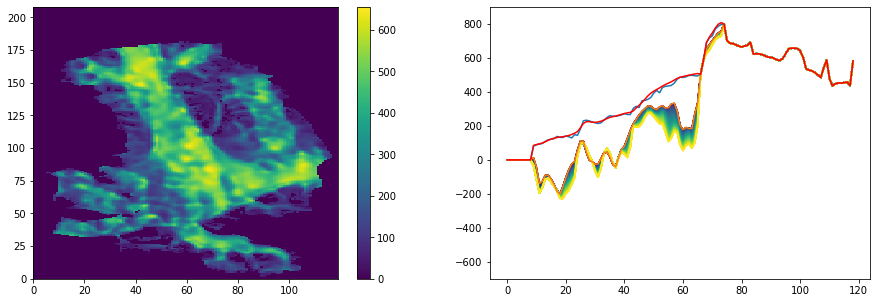

In [214]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(S_rec - B_rec)#, vmin=-50, vmax=50, cmap='RdBu')
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),1):
    lines = axes[1].plot(range(nx), B_rec_all[i][40,:], color=colors[i])
lines2 = axes[1].plot(range(nx), NPI_DEM[40,:])
lines2 = axes[1].plot(range(nx), B_init[40,:])
lines2 = axes[1].plot(range(nx), S_rec[40,:], color='r')
axes[1].set_ylim([-700,900])

In [180]:
rad_msk = radar_mask[3:-3,3:-3]
rad_msk_nan = copy(rad_msk)
rad_msk_nan[rad_msk==0] = np.nan

#H = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'thk', 0)[1:-1,1:-1]
h = gauss_filter(NPI_DEM, 1, 3)
H = np.zeros_like(h)
H[radar_mask==1] = h[radar_mask==1] - radar_bed[radar_mask==1]

x_d = np.transpose(np.where(rad_msk==1))
grid_x, grid_y = np.meshgrid(range(np.shape(radar_mask)[1]), range(np.shape(radar_mask)[0]))
rad_bed_int = griddata(x_d, (radar_bed)[radar_mask==1], (grid_y, grid_x), method='nearest')
H_int = h - rad_bed_int
H_int = gauss_filter(H_int, 1, 3)

dhdx = -(h[1:-1,1:-1] - h[1:-1,0:-2])/res
dhdy = -(h[1:-1,1:-1] - h[0:-2,1:-1])/res

alpha = (np.sqrt(dhdx**2+dhdy**2))
SIA_u = (9.8*ice_density)**3*(dhdx)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_v = (9.8*ice_density)**3*(dhdy)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_vel = np.sqrt(SIA_u**2+SIA_v**2)

SSA_u = u[1:-1, 1:-1]/secpera - SIA_u
SSA_v = v[1:-1, 1:-1]/secpera - SIA_v
SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)

SSA_u_mod = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'u_ssa', 0)
SSA_v_mod = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'v_ssa', 0)

dudx = -(SSA_u[1:-1,1:-1] - SSA_u[1:-1,0:-2])/res
dudy = -(SSA_u[1:-1,1:-1] - SSA_u[0:-2,1:-1])/res
dvdx = -(SSA_v[1:-1,1:-1] - SSA_v[1:-1, 0:-2])/res
dvdy = -(SSA_v[1:-1,1:-1] - SSA_v[0:-2,1:-1])/res

e_xy = 0.5*(dudy+dvdx)
B = A**(-1/3)
v_eff = 0.5*B*(dudx**2+dvdy**2+dudx*dvdy+0.5*e_xy**2)**(1/3)

nuH_x = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'nuH[0]', 0)
nuH_y = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'nuH[1]', 0)
nuH = np.sqrt(nuH_x**2+nuH_y**2)

s1 = 2*v_eff*H_int[2:-2,2:-2]*(2*dudx+dvdy)
s2 = v_eff*H_int[2:-2,2:-2]*(dudy+dvdx)

s3 = v_eff*H_int[2:-2,2:-2]*(dudy+dvdx)
s4 = 2*v_eff*H_int[2:-2,2:-2]*(dudx+2*dvdy)

t1 = -(s1[1:-1,1:-1] - s1[1:-1,0:-2])/res
t2 = -(s2[1:-1,1:-1] - s2[0:-2,1:-1])/res

t3 = -(s3[1:-1,1:-1] - s3[1:-1,0:-2])/res
t4 = -(s4[1:-1,1:-1] - s2[0:-2,1:-1])/res

taud_x = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdx[2:-2,2:-2]))
taud_y = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdy[2:-2,2:-2]))

tau_d = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'taud_mag', 0)[3:-3,3:-3]
tau_b = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'taub_mag', 0)[3:-3,3:-3]

taub_x = taud_x-t1-t2
taub_y = taud_y - t3 - t4
taub_cal = np.sqrt(taub_x**2+taub_y**2)

tauc_cal = -taub_cal/(SSA_vel[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)

tauc_x = -taub_x/(SSA_u[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_y = -taub_y/(SSA_v[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)
tauc_xy_s = gauss_filter(tauc_xy, 1, 3)

tauc = griddata(x_d, tauc_xy[rad_msk==1], (grid_y, grid_x), method='nearest')
tauc = gauss_filter(tauc, 1, 3)

<ipython-input-180-90171b8ebeca>:26: RuntimeWarning: invalid value encountered in sqrt
  SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)
<ipython-input-180-90171b8ebeca>:64: RuntimeWarning: invalid value encountered in sqrt
  taub_cal = np.sqrt(taub_x**2+taub_y**2)
<ipython-input-180-90171b8ebeca>:70: RuntimeWarning: invalid value encountered in sqrt
  tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)
<ipython-input-21-155111e60a30>:14: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


(0, 20000000.0)

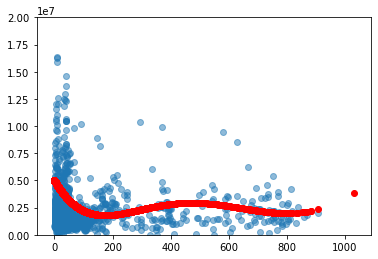

In [204]:
tauc_clean = tauc[3:-3,3:-3]
#taub_clean[taub_clean>3e5]=0
poly_tauc = np.poly1d(np.polyfit(vel_mes[3:-3,3:-3][rad_msk==1],tauc_clean[rad_msk==1],5))
tauc_fit = poly_tauc(vel_mes)

plt.scatter(vel_mes[3:-3,3:-3][rad_msk==1],tauc_clean[rad_msk==1], alpha =.5)
plt.scatter(vel_mes, tauc_fit, c='r')
plt.ylim([0, 2e7])

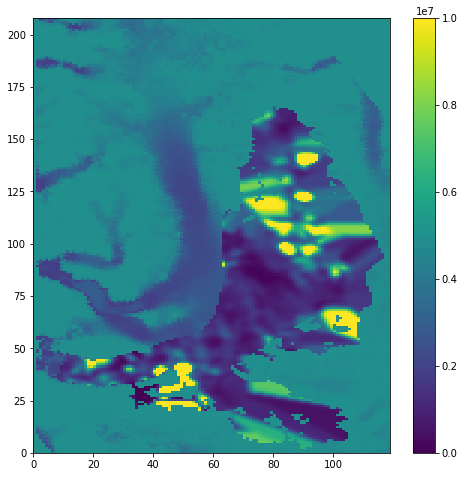

In [206]:
fig, ax = plt.subplots(figsize=(8,8))
field = ax.pcolor(tauc_rec, vmax = 1e7, vmin = 0)
fig.colorbar(field, ax = ax)

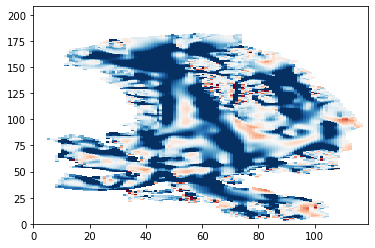

In [215]:
plt.pcolor(misfit_all[-1], cmap='RdBu', vmin=-1, vmax=1)

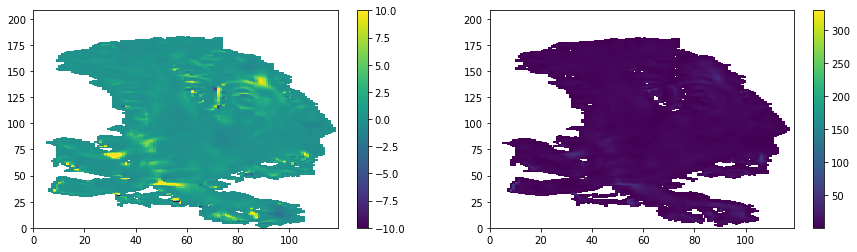

In [216]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor((vel_all[-1]-vel_all[-29])*mask, vmin = -10, vmax = 10)
field1 = ax[1].pcolor(np.maximum(0,get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velsurf_mag', 0)))
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

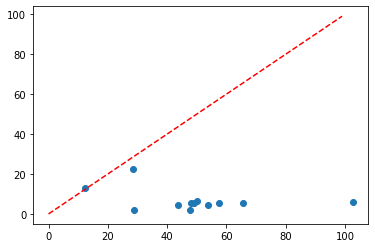

In [217]:
fig, ax = plt.subplots()
points = ax.scatter(vel_0914, get_nearest(x,y,get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velsurf_mag', 0), vel_x, vel_y))
#points = ax.scatter((SSA_vel[2:-2,2:-2]+SIA_vel[2:-2,2:-2])*rad_msk_nan*secpera, vel[3:-3,3:-3]*rad_msk_nan)
line = ax.plot(range(100), range(100), '--',c='r')
#plt.xlim([0,1000])

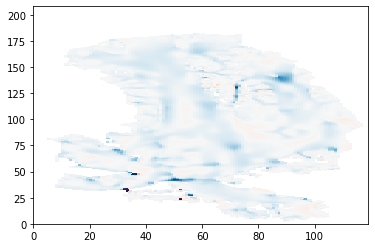

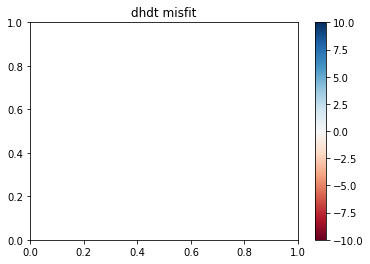

In [222]:
from IPython.display import display, clear_output #needed for animated plots

fig, axes = plt.subplots()
for i in range(0,len(B_rec_all),10):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-10, vmax=10)
    #field = axes.pcolor(S_rec_all[i]-B_rec_all[i], vmax=800, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
line = ax[0].plot(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)))
line = ax[0].plot(np.convolve(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)), np.ones(5)/5))
ax[0].set_ylim([0,3])
line2 = ax[1].plot(dh_misfit_vs_iter)
line1 = ax[1].plot(np.convolve(dh_misfit_vs_iter, np.ones(50)/50, mode='same'))

In [218]:
Z_at_rad = get_nearest(x[mask==1],y[mask==1],NPI_DEM[mask==1], x_rad, y_rad)

df = pd.DataFrame({"Z":Z_at_rad,"rad":rad[:,0], "x_rad":x_rad[:,0], "y_rad": y_rad[:,0]})
df = df.groupby('Z').mean()

df_sample = copy(df)
for q,i in enumerate(df['x_rad']):
    if i in radar_x:
        df_sample = df_sample.drop(df.index[q])

thick_ref_at_rad = df_sample.index - df_sample['rad']
thick_rec = S_rec - B_rec
thick_rec_at_rad = get_nearest(x[mask==1], y[mask==1], thick_rec[mask==1], np.array(df_sample['x_rad']), np.array(df_sample['y_rad']))

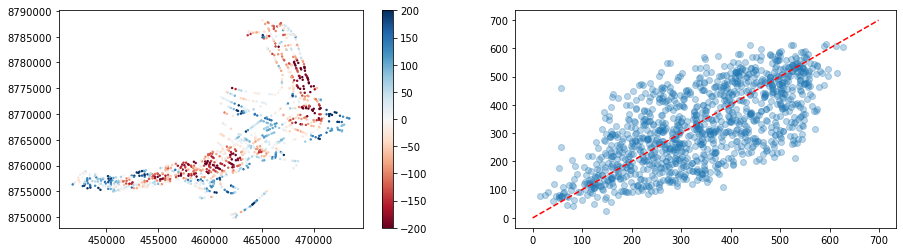

In [219]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].scatter(np.array(df_sample['x_rad']), np.array(df_sample['y_rad']), c=(thick_rec_at_rad - thick_ref_at_rad), cmap='RdBu', s=2, vmin=-200, vmax=200)
fig.colorbar(field, ax = ax[0])

scatter = ax[1].scatter(thick_ref_at_rad, thick_rec_at_rad, marker='o', alpha=.3)
line = ax[1].plot(range(700), range(700), '--', c='r')

In [ ]:
data_at_rad = get_nearest(x,y,get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'topg', 0), np.array(df['x_rad']), np.array(df['y_rad']))
#data_at_rad = get_nearest(x,y, B_rec, np.array(df['x_rad']), np.array(df['y_rad']))
fig, ax = plt.subplots(1,2, figsize=(15,4))
points = ax[0].scatter(data_at_rad, (thick_rec_at_rad - thick_ref_at_rad), alpha=.3)
points1 = ax[1].scatter(B_rec, (500+np.maximum(0, B_init))*1e5)

In [223]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thick_rec_at_rad - thick_ref_at_rad)/np.mean(thick_ref_at_rad)
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec_at_rad - thick_ref_at_rad))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
RMSE = math.sqrt(mean_squared_error(thick_ref_at_rad, thick_rec_at_rad))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

RMSE: 110.20730117137026 m
mean deviation: -0.04113223879336319 %
mean absolute deviation: 87.72943956470434 m
median deviation: -0.03669934184416573 %
Interquartile range of deviation: 0.4330374823331039
95% confidence intervall: [ 0.01875845 -0.01875845]


In [ ]:
import gdal

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def write_geotiff(array, geoinfo):
    dst_filename = '{}.tiff'.format(namestr(array, globals())[0])
    y_pixels, x_pixels = np.shape(array)  # number of pixels in x

    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
    dataset.GetRasterBand(1).WriteArray(np.flip(array, axis=0))

    # follow code is adding GeoTranform and Projection
    #geotrans=geoinfo.GetGeoTransform()  #get GeoTranform from existed 'data0'
    #proj=geoinfo.GetProjection() #you can get from a exsited tif or import 
    #dataset.SetGeoTransform(geotrans)
    #dataset.SetProjection(proj)
    #dataset.FlushCache()
    

In [ ]:
write_geotiff(Z_mean, 1)

In [ ]:
blo_org = np.zeros((9,9))
blo_org[4,4] = 1
#blo[5,4] = 1
blo = ndimage.gaussian_filter(blo_org, .7, truncate=3)
fig, ax = plt.subplots()
field = ax.pcolor(blo_org - blo)
fig.colorbar(field, ax = ax)
#print(np.max(blo-ndimage.gaussian_filter(blo, .3, 4)))

In [ ]:
    ## save output    
    import shelve
    bk = shelve.open('./KK_it300_beta.5_dt.1_tauc500Binit1e3_q.2_likebetterocean_startthin','n')
    for k in dir():
        if k in ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

In [ ]:
save_and_commit('Kronebreen-Kongsbreen.ipynb', 'Kronebreen', 'kronebreen_kongsbreen_iteration_out.nc', 'first experiment with friction inverted from radar obs')

In [224]:
def save_and_commit(notebook_path, branch_name, nc_file, commit_message):
    
    current_branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode('ascii').strip()
    if current_branch != branch_name:
        raise ValueError('not on correct branch')
        
    if (os.path.exists(nc_file) and os.path.exists('./models/') and os.path.exists('./data/')) == False:
        raise ValueError('nc_file or target folder does not exist')
    
    start_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
        
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
                
    stage = ["git", "add", "{}".format(notebook_path)]
    commit = ["git", "commit", "-m", commit_message]
    try:
        proc = subprocess.check_output(stage, stderr=subprocess.STDOUT)
        proc = subprocess.check_output(commit, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError:
        raise ValueError('something went wrong')
        
    hashmark =  subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
    save_model = ["cp", "{}".format(nc_file), "./models/{}_{}.nc".format(branch_name, hashmark)]
    proc = subprocess.check_output(save_model, stderr=subprocess.STDOUT)

    bk = shelve.open('./data/{}_{}.pkl'.format(branch_name, hashmark),'n')
    exceptions = ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']
    for k in sorted(globals()):
        if k in exceptions:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

In [139]:
import shelve

bk_restore = shelve.open('./data/Kronebreen_40c15bbcc113c6a863b5eee02faf9ecc715d6743.pkl')
if len(bk_restore) == 0:
    bk_restore.close()
    raise ValueError('nothing inside file or file does not exist')

for k in bk_restore:
    try:
        globals()[k] = bk_restore[k]
    except:
        print('Warning: {} could not be restored'.format(k))
        continue
bk_restore.close()